In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import requests
import seaborn as sns
from scipy.stats import skewnorm
import numpy as np
import json
import sys
import os

# Import modules defined in src/
sys.path.append(os.path.abspath('../src'))
from seasonality import SeasonalPlotter

In [2]:
# Set seaborn theme
sns.set_theme()

# Get data

Read your personal API key

In [3]:
with open("../api_key", "r") as file:
    API_KEY = file.read()

In [4]:
# Define the API endpoint and parameters
url = "https://api.atmo-aura.fr/api/v1/valeurs/horaire"

data = pd.DataFrame()

for site_id in ["FR15038", "FR15043", "FR15053"]:
    params = {
        "api_token": API_KEY,
        "format": "json",
        "sites": site_id,
        "date_debut": "-2 years",
        "label_court_polluant": "PM2.5",
        "order_by_date": "asc",
        "valeur_brute": "1"
    }

    # Make the GET request
    response = requests.get(url, params=params)

    response = json.loads(response.text)
    data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

    while response["links"]["next"] is not None:
        response = requests.get(response["links"]["next"])
        response = json.loads(response.text)
        data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.tz_localize(None)

In [5]:
class site():
    def __init__(self, data, site_id):
        self.data = data[data["site_id"] == site_id]

        if self.data.empty:
            raise ValueError("No data available for this site")
        
        self.site_id = site_id

        self.reference_data = self.data.query("type_appareil_id == 11")
        self.reference_values = self.reference_data.loc[:, ["valeur", "date"]]

        self.microsensor_data = self.data.query("type_appareil_id == 57")
        self.microsensor_values = self.microsensor_data.loc[:, ["valeur", "date"]]

    def get_reference_data(self):
        return self.reference_data
    
    def get_microsensor_data(self):
        return self.microsensor_data
    
    def get_reference_values(self):
        return self.reference_values
    
    def get_microsensor_values(self):
        return self.microsensor_values
    
    def filter_date(self, start_date, end_date):
        reference = self.get_reference_data()
        microsensor = self.get_microsensor_data()

        reference = reference[(reference["date"] >= start_date) & (reference["date"] <= end_date)]
        microsensor = microsensor[(microsensor["date"] >= start_date) & (microsensor["date"] <= end_date)]

        return reference, microsensor
    
    def plot(self, ax = None, *, kwargs = {}):
        if ax is None:
            ax = plt.gca()

        x_ref = self.reference_values["date"]
        y_ref = self.reference_values["valeur"]

        x_micro = self.microsensor_values["date"]
        y_micro = self.microsensor_values["valeur"]

        ax.plot(x_ref, y_ref, label="Reference values")
        ax.plot(x_micro, y_micro, label="Microsensor values")
        ax.set_title(f"PM2.5 values for site {self.site_id}")
        ax.set_xlabel("Date")
        ax.set_ylabel("PM2.5 values (µg/m³)")
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend()
    
        return ax

In [6]:
site_id_dict = {
    "Saint Martin d'Hères": "FR15038",
    "Les Frenes": "FR15043",
    "Rocade Sud": "FR15053",
}

LF = site(data, site_id_dict["Les Frenes"])
SMH = site(data, site_id_dict["Saint Martin d'Hères"])

# Descriptive statistics
On the SMH station

## Differences

In [29]:
# Filter on date
smh_reference, smh_microsensor = SMH.filter_date("2023-01-01", "2023-12-31")
lf_reference, lf_microsensor = LF.filter_date("2023-01-01", "2023-12-31")

# Split dataframe by microsensor id for les fresnes
lf_microsensor_dict = {}
for microsensor_id in ["FR15043_39_57_3_C1", "FR15043_39_57_4_C1", "FR15043_39_57_5_C1"]:
    lf_microsensor_dict[microsensor_id] = lf_microsensor[lf_microsensor["mesure_id"] == microsensor_id]

# Merge microsensor and reference data
smh_data = pd.merge(smh_reference, smh_microsensor, on="date")
lf_data = {}
for microsensor_id in ["FR15043_39_57_3_C1", "FR15043_39_57_4_C1", "FR15043_39_57_5_C1"]:
    lf_data[microsensor_id] = pd.merge(lf_reference, lf_microsensor_dict[microsensor_id], on="date")

In [31]:
# Compute difference
smh_data["diff"] = smh_data["valeur_y"] - smh_data["valeur_x"]
for microsensor_id in ["FR15043_39_57_3_C1", "FR15043_39_57_4_C1", "FR15043_39_57_5_C1"]:
    lf_data[microsensor_id]["diff"] = lf_data[microsensor_id]["valeur_y"] - lf_data[microsensor_id]["valeur_x"]

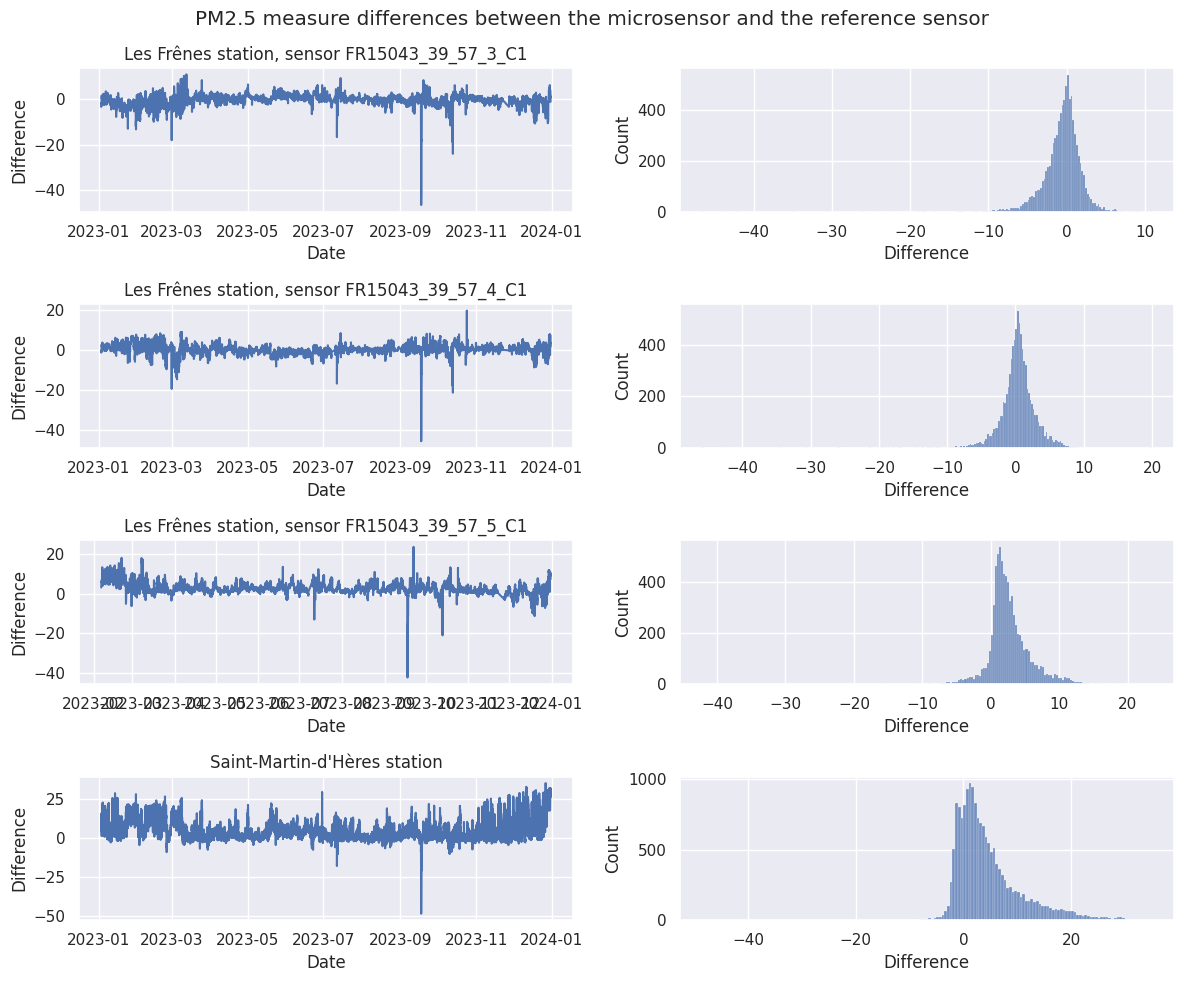

In [42]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))

for ax_idx, microsensor_id in enumerate(["FR15043_39_57_3_C1", "FR15043_39_57_4_C1", "FR15043_39_57_5_C1"]):
    axes[ax_idx, 0].plot(lf_data[microsensor_id]["date"], lf_data[microsensor_id]["diff"])
    axes[ax_idx, 0].set_xlabel("Date")
    axes[ax_idx, 0].set_ylabel("Difference")
    axes[ax_idx, 0].set_title(f"Les Frênes station, sensor {microsensor_id}")

    sns.histplot(lf_data[microsensor_id]["diff"], ax=axes[ax_idx, 1])
    axes[ax_idx, 1].set_xlabel("Difference")

axes[3, 0].plot(smh_data["date"], smh_data["diff"])
axes[3, 0].set_xlabel("Date")
axes[3, 0].set_ylabel("Difference")

sns.histplot(smh_data["diff"], ax=axes[3, 1])
axes[3, 1].set_xlabel("Difference")
axes[3, 0].set_title("Saint-Martin-d'Hères station")

plt.suptitle("PM2.5 measure differences between the microsensor and the reference sensor")
plt.tight_layout()
plt.show()


The microsensor of the Saint-Martin-d'Hères station overmeasures systematically the rate of PM2.5 relatively to its reference sensor.  
The Les Frênes microsensor is unbiased but with the same order of magnitude of deviation.

## Distribution

In [43]:
# Sample x values
xx = np.linspace(-10, 40, 100)

# Set parameters of skewed normal density function
skewness, mean, std = 5.0, 0.0, 5.3

# Compute skewed normal density function
yy = skewnorm.pdf(xx, skewness, mean, std)

Text(0.5, 1.0, "PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station")

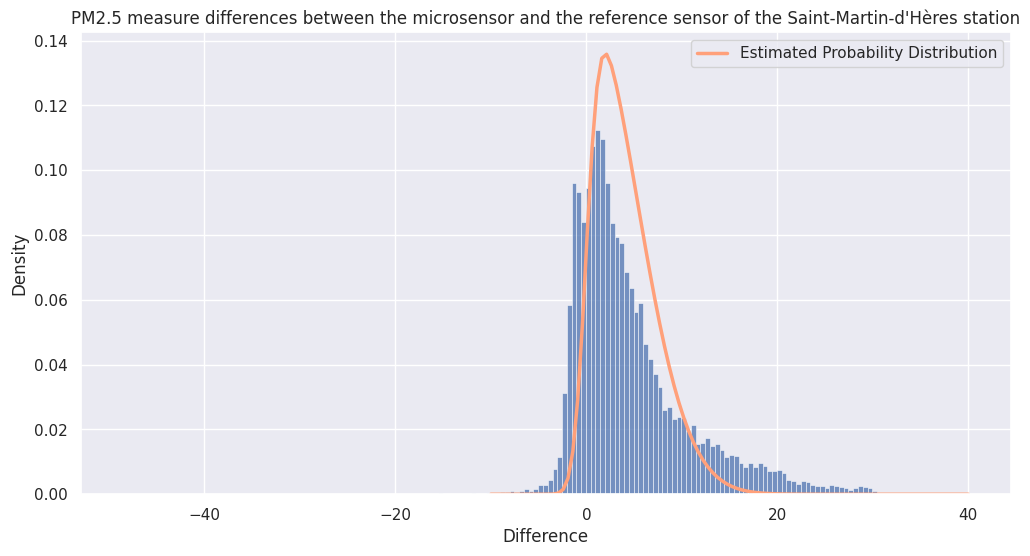

In [44]:
# Plot the estimated distribution vs the histogram
plt.figure(figsize=(12, 6))
sns.histplot(smh_data["diff"], stat="density")
plt.plot(xx, yy, label="Estimated Probability Distribution", color="#FFA07A", linewidth=2.5)
plt.legend()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.title("PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station")

## Rolling statistics

In [49]:
# Take one microsensor only for les fresnes from now
lf_data = lf_data["FR15043_39_57_3_C1"]

In [50]:
for dataset in [smh_data, lf_data]:
    for column in ['x', 'y']:
        dataset[f"moving_average_48_{column}"] = dataset[f"valeur_{column}"].rolling(48).mean()
        dataset[f"moving_variance_48_{column}"] = dataset[f"valeur_{column}"].rolling(48).var()

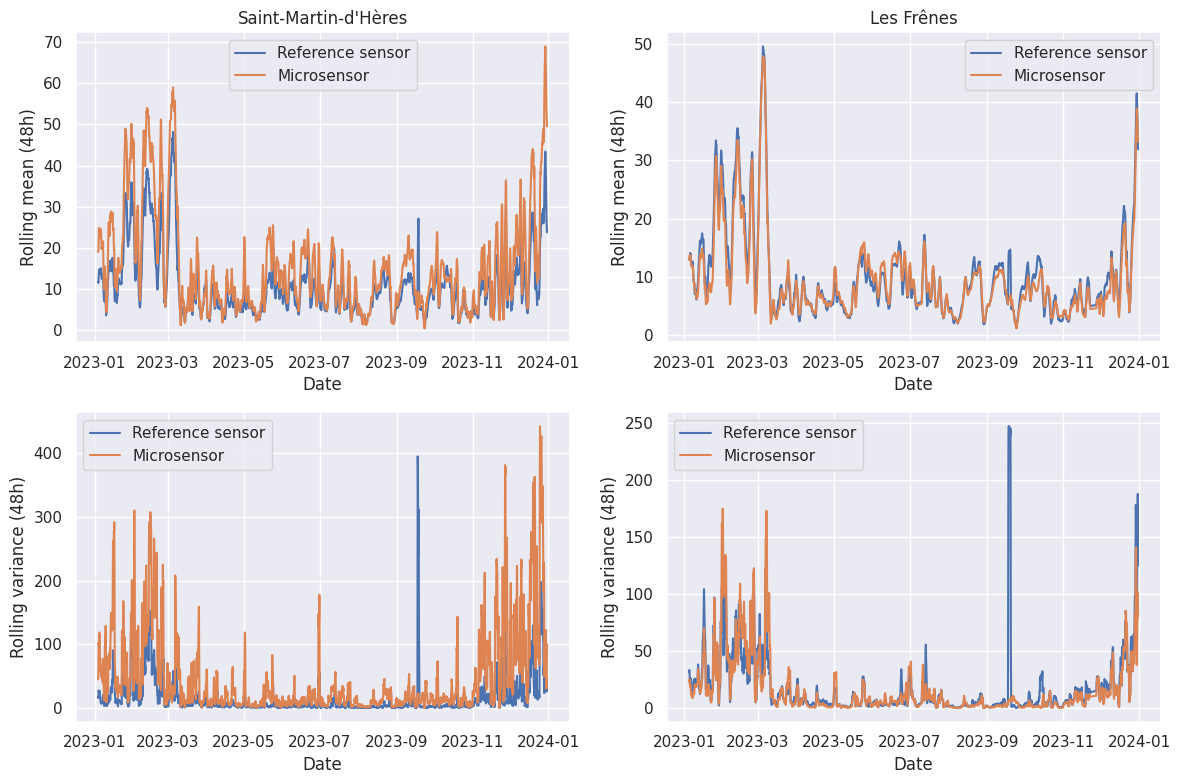

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot moving average for smh_data
axs[0, 0].plot(smh_data["date"], smh_data["moving_average_48_x"], label="Reference sensor")
axs[0, 0].plot(smh_data["date"], smh_data["moving_average_48_y"], label="Microsensor")
axs[0, 0].set_ylabel("Rolling mean (48h)")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_title("Saint-Martin-d'Hères")
axs[0, 0].legend()

# Plot moving variance for smh_data
axs[1, 0].plot(smh_data["date"], smh_data["moving_variance_48_x"], label="Reference sensor")
axs[1, 0].plot(smh_data["date"], smh_data["moving_variance_48_y"], label="Microsensor")
axs[1, 0].set_ylabel("Rolling variance (48h)")
axs[1, 0].set_xlabel("Date")
axs[1, 0].legend()

# Plot moving average for lf_data
axs[0, 1].plot(lf_data["date"], lf_data["moving_average_48_x"], label="Reference sensor")
axs[0, 1].plot(lf_data["date"], lf_data["moving_average_48_y"], label="Microsensor")
axs[0, 1].set_ylabel("Rolling mean (48h)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_title("Les Frênes")
axs[0, 1].legend()

# Plot moving variance for lf_data
axs[1, 1].plot(lf_data["date"], lf_data["moving_variance_48_x"], label="Reference sensor")
axs[1, 1].plot(lf_data["date"], lf_data["moving_variance_48_y"], label="Microsensor")
axs[1, 1].set_ylabel("Rolling variance (48h)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Seasonal plot

In [52]:
# Copy dataframe for seasonal plot
smh_data_seasonality = smh_data.copy()

In [53]:
# Set datetime column as index
smh_data_seasonality.set_index("date", inplace=True, drop=True)

In [54]:
# Adapt pandas index type for passing df to the seasonal plot function
smh_data_seasonality.index = smh_data_seasonality.index.to_period("h")

In [58]:
# Define time variables
smh_data_seasonality["dayofyear"] = smh_data_seasonality.index.dayofyear
smh_data_seasonality["hourofday"] = smh_data_seasonality.index.hour
smh_data_seasonality["monthofyear"] = smh_data_seasonality.index.month

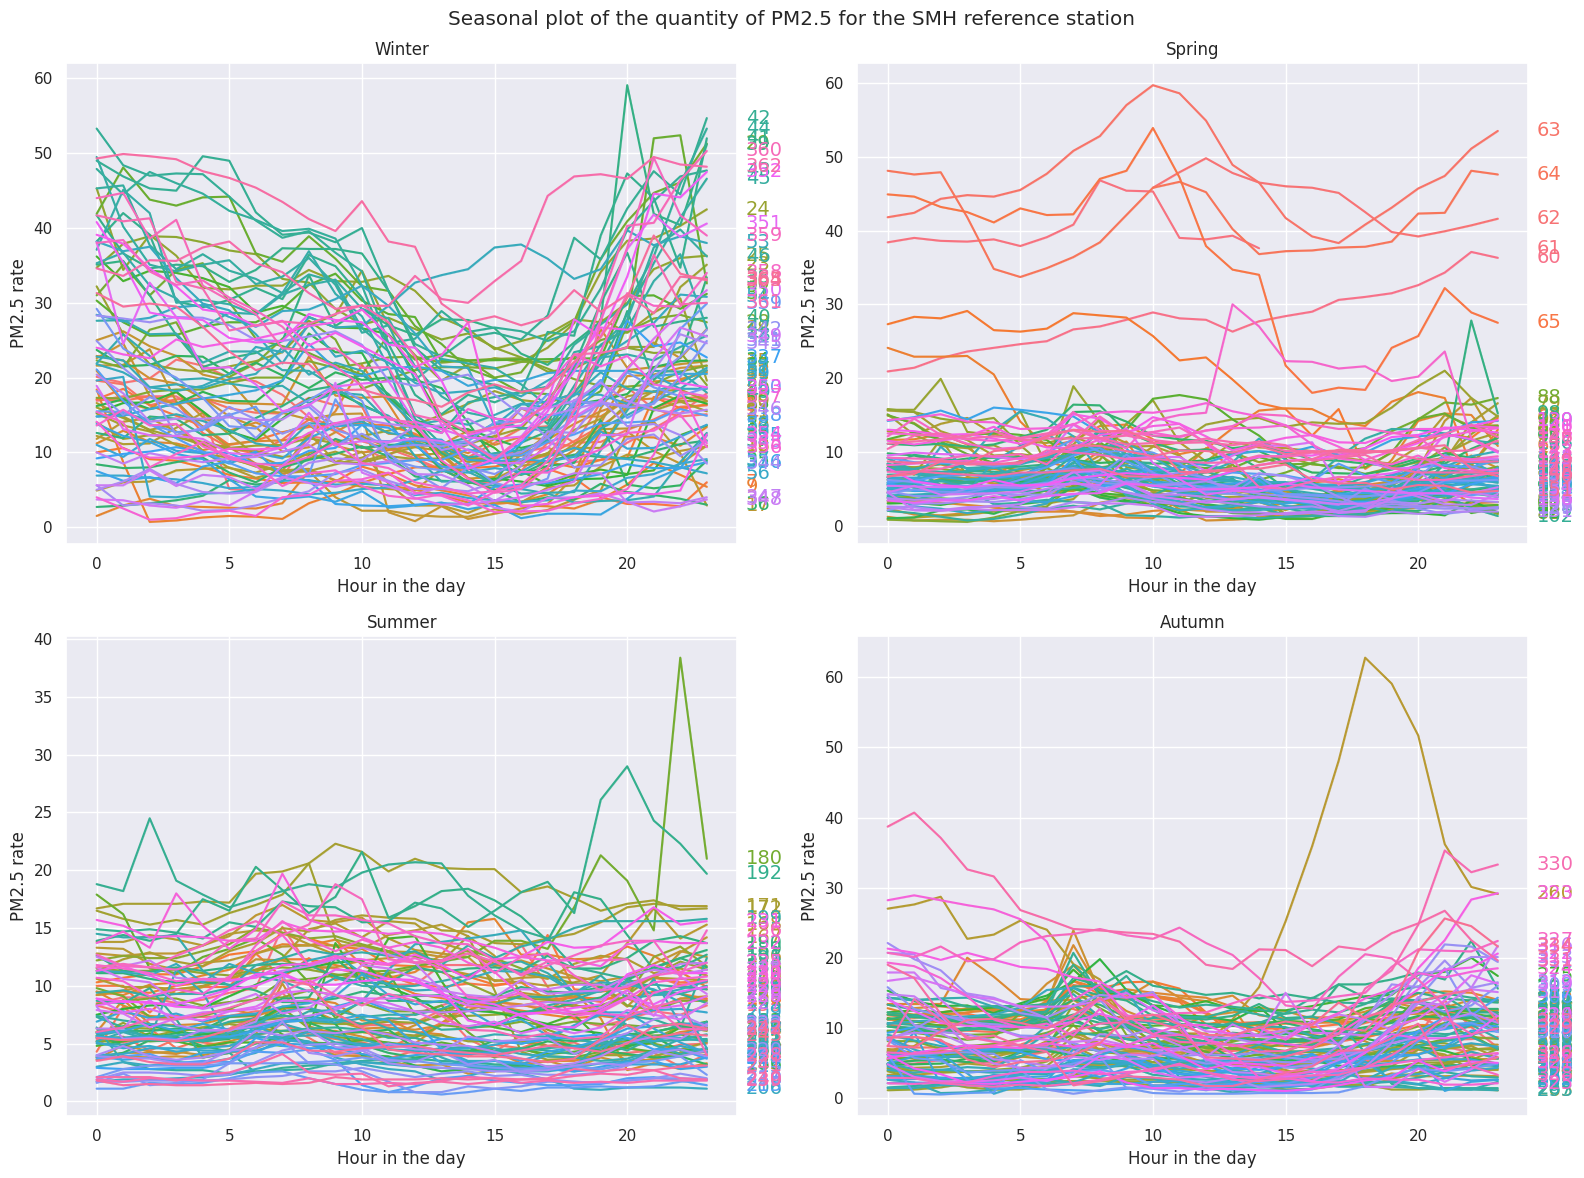

In [59]:
# Define seasons based on months
seasons = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Iterate through seasons and create plots
for i, (season, months) in enumerate(seasons.items()):
    # Filter data for the current season
    season_data = smh_data_seasonality[smh_data_seasonality["monthofyear"].isin(months)]
    
    SeasonalPlotter.seasonal_plot(
        X=season_data, 
        y="valeur_x", 
        period="dayofyear", 
        freq="hourofday", 
        ax=axes[i]
    )
    
    axes[i].set_ylabel("PM2.5 rate")
    axes[i].set_xlabel("Hour in the day")
    axes[i].set_title(season)

plt.suptitle("Seasonal plot of the quantity of PM2.5 for the SMH reference station")
plt.tight_layout()
plt.show()